<a href="https://colab.research.google.com/github/Mohit501/Denoising-AutoEnoders_/blob/main/Denoising_Auto_Encoder_for_regenerting_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Required Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.layers import Dense,Input,Flatten,Conv2D,Conv2DTranspose,Reshape
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
from PIL import Image

## Loading Images

In [2]:
(x_train,_),(x_test,_) = mnist.load_data()

## PreProcessing and Normalizing

In [3]:
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

Adding Noise to images

In [4]:
noise = np.random.normal(loc=0.5, scale=0.5, size=x_train.shape)
x_train_noisy = x_train + noise
noise = np.random.normal(loc=0.5, scale=0.5, size=x_test.shape)
x_test_noisy = x_test + noise
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [5]:
layer_filters = [32,64]
input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
latent_dim = 16

## Building The AutoEncoder

1.Encoder

In [6]:
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs

for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)


shape = K.int_shape(x)
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 16)                50192     
Total params: 69,008
Trainable params: 69,008
Non-trainable params: 0
_________________________________________________________________


2.Decoder

In [7]:
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)


for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)


outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          padding='same',
                          activation='sigmoid',
                          name='decoder_output')(x)

decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 16)]              0         
_________________________________________________________________
dense (Dense)                (None, 3136)              53312     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 28, 28, 1)         289       
Total params: 108,993
Trainable params: 108,993
Non-trainable params: 0
_____________________________________________________

 **AutoEncoder = Encoder + Decoder** 

In [8]:
autoencoder = Model(inputs,decoder(encoder(inputs)),name = 'autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Functional)         (None, 16)                69008     
_________________________________________________________________
decoder (Functional)         (None, 28, 28, 1)         108993    
Total params: 178,001
Trainable params: 178,001
Non-trainable params: 0
_________________________________________________________________


In [9]:
autoencoder.compile(loss = 'categorical_crossentropy',optimizer = 'rmsprop')


In [10]:
autoencoder.fit(x_train_noisy,x_train,epochs=10,batch_size=100)

Epoch 1/10
600/600 [==============================] - 6s 7ms/step - loss: 0.0000e+00
Epoch 2/10
600/600 [==============================] - 4s 7ms/step - loss: 0.0000e+00
Epoch 3/10
600/600 [==============================] - 4s 7ms/step - loss: 0.0000e+00
Epoch 4/10
600/600 [==============================] - 4s 6ms/step - loss: 0.0000e+00
Epoch 5/10
600/600 [==============================] - 4s 6ms/step - loss: 0.0000e+00
Epoch 6/10
600/600 [==============================] - 4s 6ms/step - loss: 0.0000e+00
Epoch 7/10
600/600 [==============================] - 4s 6ms/step - loss: 0.0000e+00
Epoch 8/10
600/600 [==============================] - 4s 6ms/step - loss: 0.0000e+00
Epoch 9/10
600/600 [==============================] - 4s 6ms/step - loss: 0.0000e+00
Epoch 10/10
600/600 [==============================] - 4s 6ms/step - loss: 0.0000e+00


In [11]:
x_decoded = autoencoder.predict(x_test_noisy)

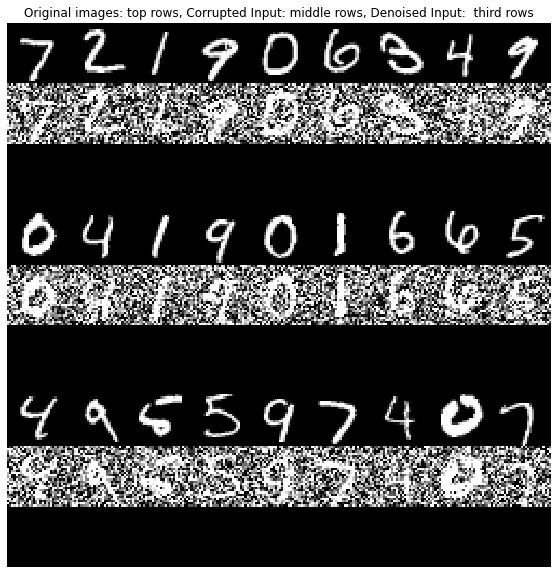

In [12]:
rows, cols = 3, 9
num = rows * cols
imgs = np.concatenate([x_test[:num], x_test_noisy[:num], x_decoded[:num]])
imgs = imgs.reshape((rows * 3, cols, image_size, image_size))
imgs = np.vstack(np.split(imgs, rows, axis=1))
imgs = imgs.reshape((rows * 3, -1, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
imgs = (imgs * 255).astype(np.uint8)
plt.figure(figsize=(25,10))
plt.axis('off')
plt.title('Original images: top rows, '
          'Corrupted Input: middle rows, '
          'Denoised Input:  third rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.show()